In [10]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [11]:
class MLQPLayer(tf.keras.layers.Layer):
    def __init__(self, n_outputs):
        super(MLQPLayer, self).__init__()
        self.n_outputs = n_outputs

    def build(self, input_shape):
        self.mu = self.add_weight('mu', shape=[int(input_shape[-1]), self.n_outputs])
        self.nu = self.add_weight('nu', shape=[int(input_shape[-1]), self.n_outputs])
        self.bias = self.add_weight('bias', shape=[1, self.n_outputs])

    def call(self, inputs, *args, **kwargs):
        return tf.matmul(inputs*inputs, self.mu) + tf.matmul(inputs, self.nu) + self.bias

In [12]:
learning_rate = 0.1
training_epochs = 5000
display_step = 100
n_idle_epochs = 1000
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=n_idle_epochs, min_delta=0.00001)

def scheduler(epoch, lr):
    if lr <= 0.01:
        return lr
    if epoch % 200 == 0:
        return lr * 0.8
        # return lr * 0.9   # best
    else:
        return lr
reduce_lr = tf.keras.callbacks.LearningRateScheduler(scheduler)

class NEPOCHLogger(tf.keras.callbacks.Callback):
    def __init__(self, per_epoch=100):
        super(NEPOCHLogger, self).__init__()
        self.seen = 0
        self.per_epoch = per_epoch

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.per_epoch == 0:
            print('Epoch {}, loss {:.8f}, mae {:.8f}'.format(epoch, logs['loss'], logs['mae']))

log_display = NEPOCHLogger(per_epoch=display_step)
train_data = pd.read_csv(r'two_spiral_train_data.txt', header=None, sep='\s+')
test_data = pd.read_csv(r'two_spiral_test_data.txt', header=None, sep='\s+')
train_data['class_0'] = train_data[2].apply(lambda x: 1 if x == 0 else 0)
train_data['class_1'] = train_data[2].apply(lambda x: 1 if x == 1 else 0)
test_data['class_0'] = test_data[2].apply(lambda x: 1 if x == 0 else 0)
test_data['class_1'] = test_data[2].apply(lambda x: 1 if x == 1 else 0)

train_X = tf.convert_to_tensor(np.asarray(train_data.iloc[:, 0:2]))
train_y = tf.convert_to_tensor(np.asarray(train_data.iloc[:, 2]))
test_X = tf.convert_to_tensor(np.asarray(test_data.iloc[:, 0:2]))
test_y = tf.convert_to_tensor(np.asarray(test_data.iloc[:, 2]))

model = tf.keras.Sequential([
    MLQPLayer(128),
    tf.keras.layers.Activation('leaky_relu'),
    MLQPLayer(1),
    tf.keras.layers.Activation('sigmoid')
])

optimizer = tf.keras.optimizers.SGD(learning_rate)
model.compile(loss='mse', optimizer=optimizer, metrics=['mae'])

In [17]:
history = model.fit(train_X, train_y, epochs=training_epochs, verbose=0, batch_size=16, callbacks=[log_display, reduce_lr])
print("Train Finished!", history)

y_hat_train = model.predict(train_X, verbose=0)
y_hat_test = model.predict(test_X, verbose=0)
print('total number of test samples: %d' % len(test_y))
print(model.evaluate(test_X, test_y, verbose=0))

Epoch 0, loss 0.01251822, mae 0.04436459
Epoch 100, loss 0.01269749, mae 0.04497076
Epoch 200, loss 0.01259947, mae 0.04389774
Epoch 300, loss 0.01324321, mae 0.04554089
Epoch 400, loss 0.01276852, mae 0.04461576
Epoch 500, loss 0.02249026, mae 0.05690987
Epoch 600, loss 0.01242202, mae 0.04304635
Epoch 700, loss 0.01223564, mae 0.04264383
Epoch 800, loss 0.01234630, mae 0.04270438
Epoch 900, loss 0.01209591, mae 0.04170753
Epoch 1000, loss 0.01217526, mae 0.04191937
Epoch 1100, loss 0.01271930, mae 0.04216308
Epoch 1200, loss 0.01211813, mae 0.04121643
Epoch 1300, loss 0.01213903, mae 0.04091994
Epoch 1400, loss 0.01204960, mae 0.04107210
Epoch 1500, loss 0.01192351, mae 0.04014473
Epoch 1600, loss 0.01190546, mae 0.04010974
Epoch 1700, loss 0.01432430, mae 0.04330290
Epoch 1800, loss 0.01186166, mae 0.03967176
Epoch 1900, loss 0.01180011, mae 0.03938175
Epoch 2000, loss 0.01179994, mae 0.03917811
Epoch 2100, loss 0.01202898, mae 0.03894326
Epoch 2200, loss 0.01182125, mae 0.03931560


In [18]:
class_0_area, class_1_area = {}, {}
for x in np.arange(-6, 6.1, 0.5):
    for y in np.arange(-6, 6.1, 0.5):
        if model.predict([[x, y]], verbose=0)[0][0] > 0.5:
            class_1_area.setdefault('x', []).append(x)
            class_1_area.setdefault('y', []).append(y)
        else:
            class_0_area.setdefault('x', []).append(x)
            class_0_area.setdefault('y', []).append(y)

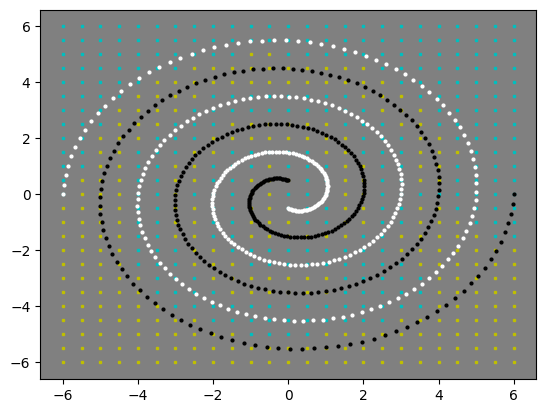

In [19]:
class_0, class_1 = {}, {}
for X, y in zip(np.concatenate([train_X.numpy(), test_X.numpy()], 0), np.concatenate([train_y.numpy(), test_y.numpy()], 0)):
    if y == 0:
        class_0.setdefault('x', []).append(X[0])
        class_0.setdefault('y', []).append(X[1])
    else:
        class_1.setdefault('x', []).append(X[0])
        class_1.setdefault('y', []).append(X[1])
plt.axes().set_facecolor('gray')
plt.plot(class_0_area['x'], class_0_area['y'], 'cs', markersize=2, label='class 0 area')
plt.plot(class_1_area['x'], class_1_area['y'], 'ys', markersize=2, label='class 1 area')
plt.plot(class_0['x'], class_0['y'], 'wo', markersize=2, label='class 0')
plt.plot(class_1['x'], class_1['y'], 'o', markersize=2, color='#000000', label='class 1')
plt.show()